In [1]:
import numpy as np
import tensorflow as tf
import copy
import itertools
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, poisson, norm

import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
from utils import *
from gen_inputs import *
from functs_inputs import *
from sim_hLN import *
from train_hLN import *
from init_hLN import *

matplotlib.rcParams["savefig.dpi"] = 200
matplotlib.rcParams["legend.frameon"] = False

## Now begin training of complex models, attempting to produce figure similar to S2 in Ujfalussy paper


### First step is to define a hierarchical clustering for the inputs - then they can be distributed correctly according to each hLN architecture


In [2]:
# list of lists for this maybe? e.g. the following:
clusts = [[[[[0, 1],[2]],[[3, 4],[5, 6]]],[[[7, 8],[9]],[[10, 11],[12]]]]]

In [3]:
### Define the different hLN architectures we will be using:
# 1L
Jc_1l = np.array([0])
# 1N
Jc_1n = np.array([0])
# 2N
Jc_2n = np.array([0, 1, 1])
# 3N
Jc_3n = np.array([0, 1, 1, 2, 2, 3, 3])
# 4N
Jc_4n = np.array([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [4]:
# Get some realistic inputs
X_tot = tf.convert_to_tensor(np.load('../Data/real_inputs.npy'), dtype=tf.float32)  # real inputs made earlier
X_e = X_tot[:629] # 629 excitatory inputs, in 13 ensembles
X_i = X_tot[629:] # 120 inhibitory inputs, also in 13 ensembles
# remember 1st inhibitory inputs is the somatic input - must always go to root subunit
# n_timepoints = 1000
# start = 100
inputs = X_tot

In [5]:
# Split the data into training and test sets, 80/20 initially
split=0.8
L = inputs.shape[1]
n_train = int(L * split)
train_inputs = inputs[:, :n_train]
test_inputs = inputs[:, n_train:]
print(train_inputs.shape, test_inputs.shape)

(749, 38400) (749, 9600)


In [7]:
# # just do single unit now for demonstration
# Wce_1l = [np.arange(0, n_e, 1)] #all input excitatory neurons connected to root subunit
# Wci_1l = [np.arange(n_e, n_e + n_i, 1)] #all input inhibitory neurons connected to root subunit
Wce_1l, Wci_1l = create_weights(Jc_1l, n_levels=1, clusts=clusts)
Wce_2n, Wci_2n = create_weights(Jc_2n, n_levels=2, clusts=clusts)
Wce_3n, Wci_3n = create_weights(Jc_3n, n_levels=3, clusts=clusts)
Wce_4n, Wci_4n = create_weights(Jc_4n, n_levels=4, clusts=clusts)

[[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
   18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
   36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
   54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
   72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
   90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
  108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
  126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
  144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
  162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
  180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
  198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
  216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
  234 235 236 237 238 239 240 241 242 

In [18]:
# initialise a known version each of the models to generate data with: save the parameter somewhere
hln_1l = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([False]))
# save the parameters that generated data - initialised randomly upon model creation
# params_1l = [param.numpy() for param in hln_1l.params]
# np.save("../Data/params_1l.npy", np.array(params_1l))
params_1l = np.load("../Data/params_1l.npy")
for i in range(len(params_1l)):
    hln_1l.params[i].assign(params_1l[i])
# hln_1n = hLN_Model(Jc=Jc_1l, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))

# hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True]*len(Jc_3n)))

# hln_4n = hLN_Model(Jc=Jc_4n, Wce=Wce_4n, Wci=Wci_4n, sig_on=tf.constant([True]*len(Jc_4n)))

In [19]:
# generate output data from realistic inputs - save this somewhere
# target_1l = hln_1l(inputs)
target_1l = tf.convert_to_tensor(np.load('../Data/target.npy'), dtype=tf.float32)  # real output made earlier
# np.save("../Data/target_1l.npy", target_1l.numpy())

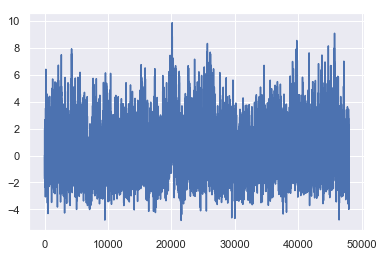

In [20]:
# pick one target to train all models for
plt.plot(target_1l.numpy())
train_target = target_1l[:n_train]
test_target = target_1l[n_train:]
plt.show()

## NOW GO TO TRAINING LOOP

In [10]:
# first add the new leaves, linear settings at first
hln_2l = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, False, False])
update_arch(prev_model=hln)

hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True]))
# update_arch(prev_model=hln_1l, next_model=hln_2n)

update_arch(prev_model=hln_1l, next_model=hln_2n)
# output_2n = hln_2n(inputs)                                                                        

In [11]:
output_2n = hln_2n(inputs)

1.1414661


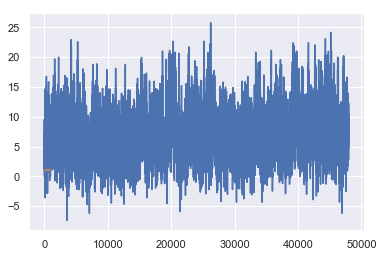

In [13]:
# plt.plot(output_2n.numpy())
print(np.mean(output_2n.numpy()-target_1l.numpy()))
plt.plot(output_2n.numpy())
plt.plot(output_2n.numpy()[:1000]-target_1l.numpy()[:1000])
plt.show()

In [15]:
hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([False]*7))
update_arch(prev_model=hln_2n, next_model=hln_3n)
output_3n = hln_3n(inputs)

-0.16852614


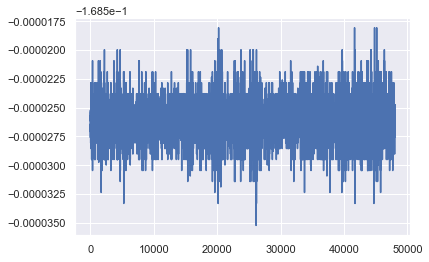

<tf.Variable 'Variable:0' shape=(7,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0.], dtype=float32)>


In [18]:
print(np.mean(output_3n.numpy()-target_1l.numpy()))
plt.plot(output_3n.numpy())
plt.plot(output_3n.numpy()-target_1l.numpy())
plt.show()

In [21]:
# change parameters from ground truth
# probably want to create a new model here in order to preserve parameter information
hln_1l.randomise_parameters() 

In [28]:
# initialise 1L model, and optimise for data
# define optimizer
optimizer_1l = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.0005)
# train model conventionally
# loss_values, accuracies = train(model=hln_1l, num_epochs=5, optimizer=optimizer_1l, inputs=train_inputs[:, :100], target=train_target[:100])
# train model with SGD
loss_values, accuracies = train_sgd(model=hln_1l, num_epochs=200, optimizer=optimizer_1l, inputs=train_inputs, target=train_target)
# for continued training


100%|██████████| 200/200 [26:22<00:00,  7.40s/it]

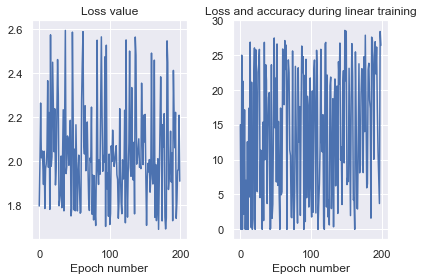

In [29]:
# visualise results from 1L training
plt.figure(1)

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss value')
plt.xlabel('Epoch number')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Prediction accuracy (%)')
plt.xlabel('Epoch number')

plt.title('Loss and accuracy during linear training')
plt.tight_layout()

# output = hln_1l(inputs[:10000])

# plt.figure(2)
# plt.plot(target_1l.numpy(), label='Target signal')
# plt.plot(output.numpy(), label='Linear model after training')
# # plt.plot(first_output.numpy(), label='Model before training')
# plt.xlabel('Time (s)')
# # plt.ylabel('Membrane potential (arbitrary units)')
# plt.title('Membrane potential (in arbitrary \n units) over time')
# plt.legend()
# plt.savefig("sgd_untied_parameters.png")
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in float_scalars


v0, variance explained: -inf
logJw variance explained: -inf
Wwe variance explained: -0.9467166662216187
Wwi variance explained: -0.9133267402648926
Taue variance explained: -1.1719796657562256
Taui variance explained: -1.0838453769683838
Th variance explained: -inf
logDelay variance explained: -inf


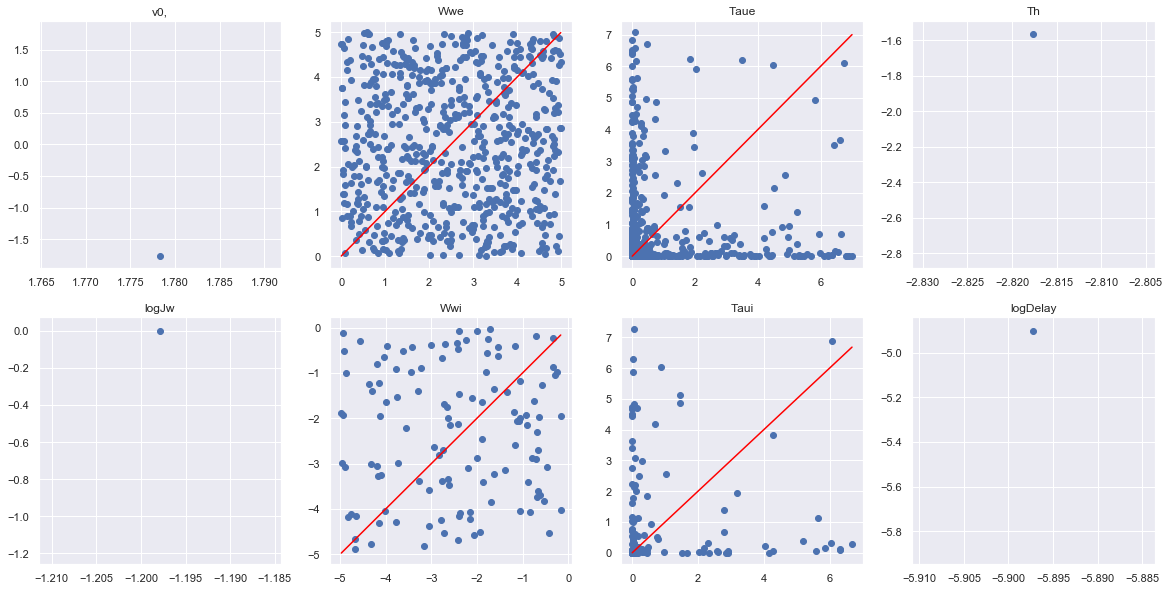

In [30]:
# create plots to compare trained parameters with target parameters:
trained_params = [param.numpy() for param in hln_1l.params]
target_params = np.load("../Data/params_1l.npy")
np.save("../Data/trained_params.npy", np.array(trained_params))

fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20,10)
i = 0
param_names = ["v0,", "logJw", "Wwe", "Wwi", "Taue", "Taui", "Th", "logDelay"]
for col in range(4):
    for row in range(2):
        p_trained, p_target = trained_params[i].flatten(), target_params[i].flatten()
        if 4 <= i <= 5:
            p_trained, p_target = np.exp(p_trained), np.exp(p_target)
        ax[row, col].scatter(p_trained, p_target)
        x = np.linspace(min(p_trained), max(p_trained), 100)
        ax[row, col].plot(x, x, color='red')
        ax[row, col].set_title(param_names[i])
        var_explained = 1 - ((p_trained - p_target)**2).mean()/np.var(p_target)
        print(param_names[i], "variance explained:", min(0, var_explained))
        i += 1
        
# #         ax[size, angle].axis('off') # no axes
        
#         ax[size, angle].set_yticklabels([])
#         ax[size,angle].set_xticklabels([])
#         ax[size,angle].grid(False)
#         #ax.set_position([0, 0, 1, 1])
#         ax[size, angle].set_aspect('equal', 'datalim')
        


In [32]:
output_1l = hln_1l(test_inputs)


8
Test data accuracy: 27.66055464744568


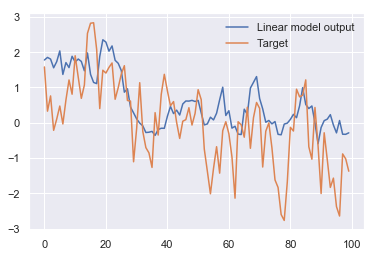

In [37]:
print(len(hln_1l.trainable_params))
test_loss = loss(predicted_v=output_1l, target_v=test_target)
test_accuracy = 100 * (1 - (test_loss.numpy()/np.var(test_target)))
print("Test data accuracy:", test_accuracy)
plt.plot(output_1l.numpy()[:100], label='Linear model output')
plt.plot(test_target.numpy()[:100], label='Target')
plt.legend()
plt.show()

In [26]:
# initialise 1N model, optimise
hln_1n = hLN_Model(Jc=Jc_sing, Wce=Wce_1l, Wci=Wci_1l, sig_on=tf.constant([True]))
# # set parameters to those of the linear model
# for i in range(len(hln_1n.params)):
#     hln_1n.params[i].assign(trained_params[i])
#     hln_1n.trainable_params[i].assign(trained_params[i])
    
# change parameters such that nonlinearity is approximately linear
init_nonlin(X=inputs, model=hln_1n, lin_model=hln_1l, nSD=100)


AttributeError: 'NoneType' object has no attribute 'shape'

In [24]:
# initialise 1L model, and optimise for data
# define optimizer
optimizer_1n = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001)
# train model conventionally
# loss_values, accuracies = train(model=hln_1l, num_epochs=5, optimizer=optimizer_1l, inputs=train_inputs[:, :100], target=train_target[:100])
# train model with SGD
loss_values, accuracies = train_sgd(model=hln_1l, num_epochs=1000, optimizer=optimizer_1n, inputs=train_inputs, target=train_target)
# for continued training

100%|██████████| 1000/1000 [30:40<00:00,  2.12s/it]


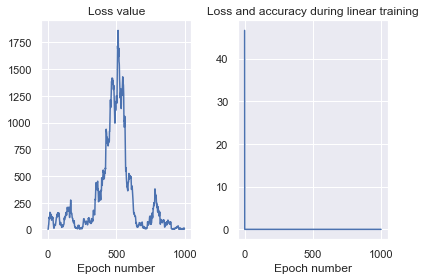

In [25]:
# visualise results from 1N training
plt.figure(1)

plt.subplot(1, 2, 1)
plt.plot(loss_values)
plt.title('Loss value')
plt.xlabel('Epoch number')

plt.subplot(1, 2, 2)
plt.plot(accuracies)
plt.title('Prediction accuracy (%)')
plt.xlabel('Epoch number')

plt.title('Loss and accuracy during linear training')
plt.tight_layout()

# output = hln_1l(inputs[:10000])

# plt.figure(2)
# plt.plot(target_1l.numpy(), label='Target signal')
# plt.plot(output.numpy(), label='Linear model after training')
# # plt.plot(first_output.numpy(), label='Model before training')
# plt.xlabel('Time (s)')
# # plt.ylabel('Membrane potential (arbitrary units)')
# plt.title('Membrane potential (in arbitrary \n units) over time')
# plt.legend()
# plt.savefig("sgd_untied_parameters.png")
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in float_scalars


v0, variance explained: -inf
logJw variance explained: -inf
Wwe variance explained: -3.0537428855895996
Wwi variance explained: -4.382689952850342
logTaue variance explained: -0.9816312789916992
logTaui variance explained: -1.2639641761779785
Th variance explained: -inf
logDelay variance explained: -inf


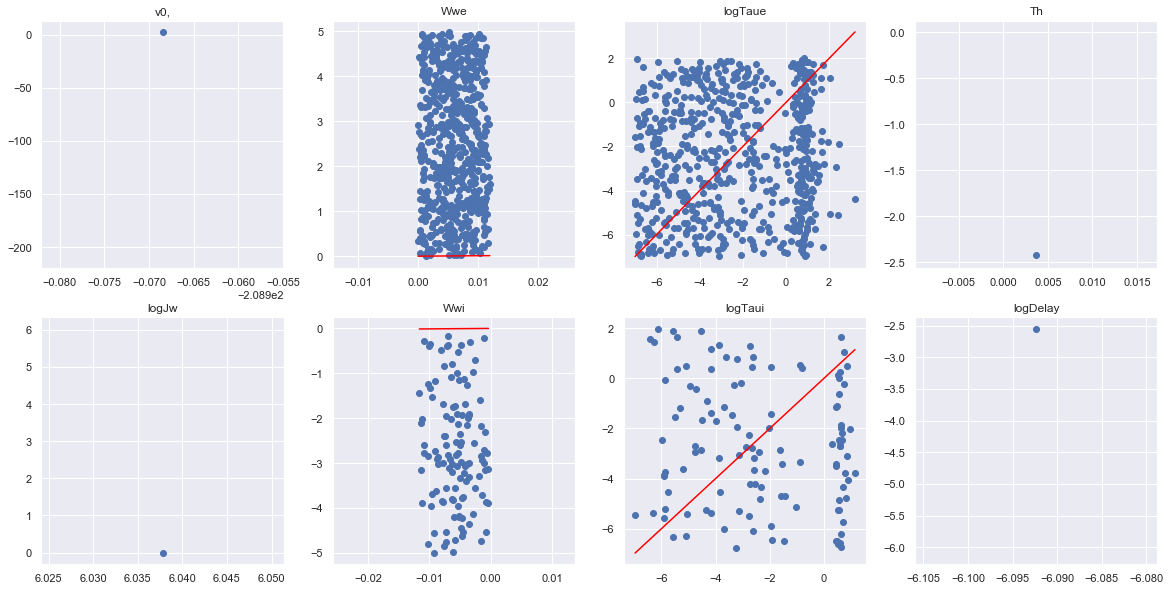

In [23]:
# create plots to compare trained parameters with target parameters:
trained_params = [param.numpy() for param in hln_1n.params]
target_params = np.load("../Data/params_1l.npy")
np.save("../Data/trained_params.npy", np.array(trained_params))

fig, ax = plt.subplots(nrows=2, ncols=4)
fig.set_size_inches(20,10)
i = 0
param_names = ["v0,", "logJw", "Wwe", "Wwi", "logTaue", "logTaui", "Th", "logDelay"]
for col in range(4):
    for row in range(2):
        p_trained, p_target = trained_params[i].flatten(), target_params[i].flatten()
        ax[row, col].scatter(p_trained, p_target)
        x = np.linspace(min(p_trained), max(p_trained), 100)
        ax[row, col].plot(x, x, color='red')
        ax[row, col].set_title(param_names[i])
        var_explained = 1 - ((p_trained - p_target)**2).mean()/np.var(p_target)
        print(param_names[i], "variance explained:", min(0, var_explained))
        i += 1
        


<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([7.261834], dtype=float32)>


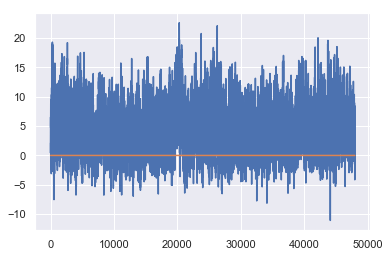

In [14]:
print(hln_1n.logJw)
plt.plot(output_1n.numpy())
plt.plot(output_1n.numpy()-target_1l.numpy())
plt.show()

In [ ]:
### create whole new function for process in this cell 
# initialise 2N model, optimise

# first add the new leaves, linear settings at first
hln_2l = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, False, False])

# redistribute the inputs to the new leaves according to the hierarchical clustering
update_arch(prev_model=hln_1n, next_model=hln_2l)                   


# now initalise the nonlinearities to approximate linear integration as before 
hln_2n = hLN_Model(Jc=Jc_2n, Wce=Wce_2n, Wci=Wci_2n, sig_on=tf.constant([True, True, True])
init_nonlin(X=inputs, model=hln_2n, lin_model=hln_2l, nSD=100)                   

# then optimise


In [ ]:
# initialise 3N model, optimise
# first add the new leaves, linear settings at first
hln_3l = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, False, False, False, False])

# redistribute the inputs to the new leaves according to the hierarchical clustering
update_arch(prev_model=hln_2n, next_model=hln_3l)                   


# now initalise the nonlinearities to approximate linear integration as before 
hln_3n = hLN_Model(Jc=Jc_3n, Wce=Wce_3n, Wci=Wci_3n, sig_on=tf.constant([True, True, True, True, True, True, True])
init_nonlin(X=inputs, model=hln_3n, lin_model=hln_3l, nSD=100)   
                   
# then optimise                   

In [ ]:
# initialise 4N model, optimise - try this later probably

In [ ]:
# compare results